In [1]:
import sys
sys.path.append("../../")

from transportnet import net
from transportnet import line
from transportnet import vehicle
from stochastic import stochastic

from genetics import ga
import tools

from matplotlib import pyplot as plt
from scipy import stats as ss
import numpy as np

In [2]:
n = net.Net()

n.load_nodes_from_file('verkhnodniprovsk_nodes.txt')
# define the network configuration
n.load_from_file('verkhnodniprovsk_edges.txt')

# define demand intensity
for nd in n.nodes:
    nd.s_interval = stochastic.Stochastic(law=2, scale=30)
central = n.get_node(code=1)
central.s_interval = stochastic.Stochastic(law=2, scale=5)

# define a set of public transport lines
line1 = line.Line(n, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
                    13, 12, 11, 15, 16, 17, 18, 19, 1], 
                    [1, 14])
line1.same_back_direction = False
line1.color = 'red'
line1.add_vehicles([vehicle.Vehicle(18)])

line2 = line.Line(n, [1, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 18, 31, 32, 16, 10, 1],
                    [1, 1])
line2.same_back_direction = False
line2.color = 'green'
line2.add_vehicles([vehicle.Vehicle(50)])
line3 = line.Line(n, [1, 20, 33, 34, 35, 36, 37, 38,
                    37, 39, 36, 35, 18, 19, 1],
                    [1, 38])
line3.same_back_direction = False
line3.color = 'brown'
line3.add_vehicles([vehicle.Vehicle(18)])
line4 = line.Line(n, [1, 3, 4, 40, 41, 42, 43, 44,
                    43, 42, 41, 40, 4, 3, 1],
                    [1, 44])
line4.same_back_direction = True
line4.color = 'blue'
line4.add_vehicles([vehicle.Vehicle(38)])
line5 = line.Line(n, [1, 3, 4, 40, 41, 42, 45, 46, 47,
                    46, 45, 42, 41, 40, 4, 3, 1],
                    [1, 47])
line5.same_back_direction = True
line5.color = 'grey'
line5.add_vehicles([vehicle.Vehicle(38)])

n.lines.extend([line1, line2, line3, line4, line5])

## Simulate net

In [3]:
sim_time = 2.0 * 60
n.duration = sim_time
model_runs = 300

def fitness_function(shifts):
    res = []
    for _ in range(model_runs):
        n.reset()
        for idx in range(len(n.lines)):
            n.lines[idx].schedule_shift = shifts[idx]
        n.gen_demand(duration=n.duration)
        x = n.simulate(sim_time)
        res.append(x)
    return np.array(res)

mean_ff = lambda xs: fitness_function(xs).mean()

res = fitness_function([75, 90, 30, 95, 0])
res.mean(), mean_ff([0, 0, 0, 0, 0])

(48.846992021294305, 42.723564338919786)

In [15]:
def needed(xs, alpha=0.05):
    mean = xs.mean()
    var = xs.var()
    u_alpha = ss.norm.ppf(1 - alpha)
    return var * u_alpha**2 / (alpha * mean)**2
needed(res)

2.5784677336215593

In [18]:
model_runs = 5
fitness_function([0, 0, 0, 0, 0])

array([39.29852941, 42.47156398, 44.05989583, 40.76875   , 43.60160428])

## Run GA

In [ ]:
winners = []
for pop_size in range(20, 220, 20):
    print(pop_size)
    g = ga.GA()
    g.chromosome_size = len(n.lines), 7
    g.population_size = pop_size
    g.generations = 10
    g.crossover_probability = 0.5
    g.mutation_probability = 0.2
    g.mutation_turns = 3
    g.fitness_function = lambda xs: fitness_function(xs).mean()
    winner = g.run()
    winners.append(winner[1])
    print()

20
winner #1 ([39, 31, 79, 58, 34], (43.655881414752855, <genetics.chromosome.Chromosome object at 0x13c3f8760>))
winner #2 ([50, 26, 16, 34, 39], (43.0554240659881, <genetics.chromosome.Chromosome object at 0x13c555870>))
winner #3 ([4, 7, 31, 66, 39], (42.562068250084245, <genetics.chromosome.Chromosome object at 0x13e189960>))
winner #4 ([4, 26, 26, 34, 47], (40.85702689264248, <genetics.chromosome.Chromosome object at 0x13c554fd0>))
winner #5 ([4, 7, 31, 64, 39], (42.01930367274814, <genetics.chromosome.Chromosome object at 0x104a2ab60>))
winner #6 ([4, 7, 31, 65, 39], (42.34093487914099, <genetics.chromosome.Chromosome object at 0x13c555150>))
winner #7 ([20, 7, 31, 65, 7], (40.95922843392792, <genetics.chromosome.Chromosome object at 0x13c5568c0>))
winner #8 ([20, 7, 31, 65, 7], (41.12836004402008, <genetics.chromosome.Chromosome object at 0x13c5568c0>))
winner #9 ([20, 7, 23, 65, 7], (41.255300955269284, <genetics.chromosome.Chromosome object at 0x13c555060>))
winner #10 ([20, 7

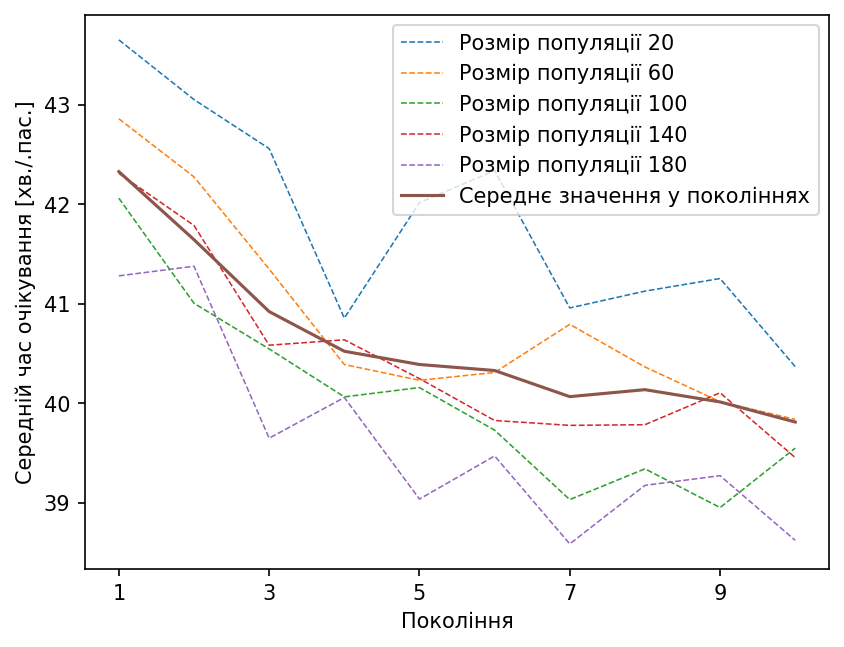

In [ ]:
winners = np.array(winners)

In [ ]:
np.array(winners).tofile('net_SP_10x10.txt', sep=',', format='%s')

## Analyze results

In [2]:
xs = np.fromfile('net_results/net_SP_10x10.txt', sep=',').reshape((10, 10))

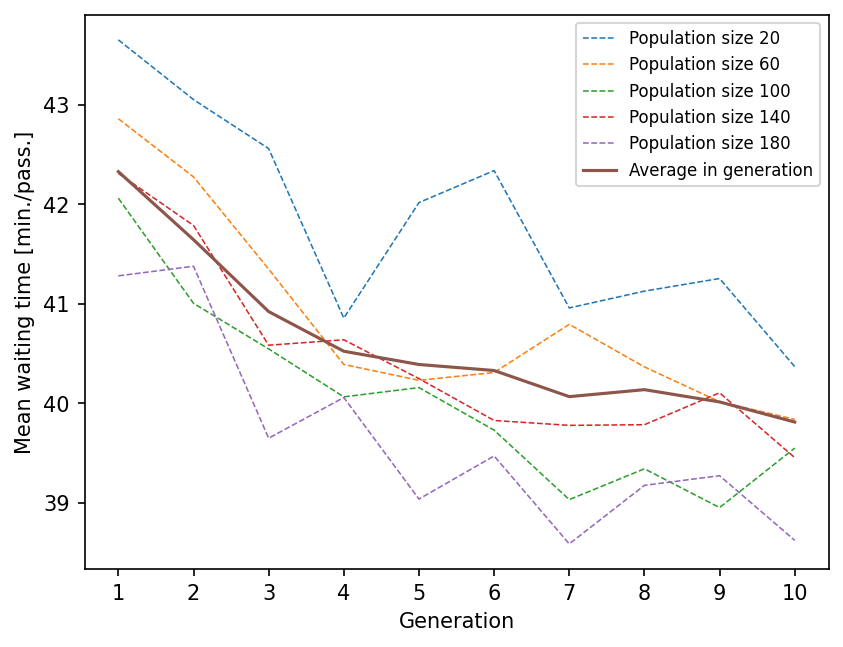

In [3]:
plt.figure(dpi=150)
idx = 0
for SP in range(20, 220, 40):
    # plt.plot(range(1, 11), xs[idx*2],lw=0.75, label=f'Розмір популяції {SP}', linestyle='--')
    plt.plot(range(1, 11), xs[idx*2],lw=0.75, label=f'Population size {SP}', linestyle='--')
    idx += 1
# plt.plot(range(1, 11), xs.mean(axis=0), lw=1.5, label=f'Середнє значення у поколіннях')
plt.plot(range(1, 11), xs.mean(axis=0), lw=1.5, label=f'Average in generation')
# plt.ylabel('Середній час очікування [хв./.пас.]')
# plt.xlabel('Покоління')
plt.ylabel('Mean waiting time [min./pass.]')
plt.xlabel('Generation')
plt.xticks(range(1, 11))
plt.legend(fontsize=8)
plt.show()

intercept=40.47980574547891
coefs=[-0.00778897]
R2=0.6083986325332094
t_alfa(0.05,8)=2.3060041350333704
coef1	True	-0.010147380708346618	-0.005430556990864659
intercept=43.63016100424784
coefs=[-0.01146008]
R2=0.5649888390690182
t_alfa(0.05,8)=2.3060041350333704
coef1	True	-0.015255242112776997	-0.0076649273306194764
intercept=41.64082698801609
coefs=[-0.00930545]
R2=0.7049569315561248
t_alfa(0.05,8)=2.3060041350333704
coef1	True	-0.011577466231902277	-0.0070334416450384615


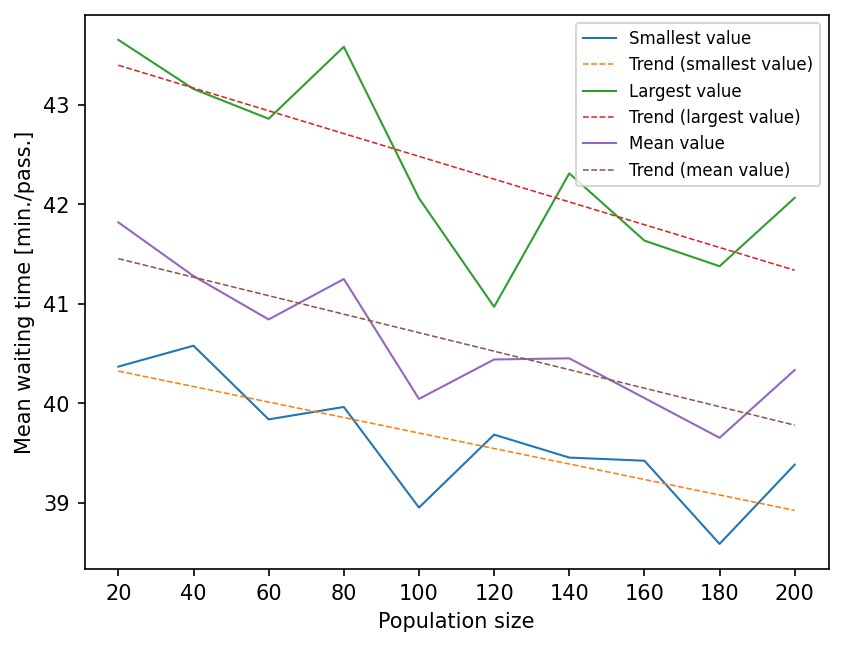

In [4]:
xticks = range(20, 220, 20)
alpha = 0.05

X = np.array([[x for x in xticks]]).T
rm_min = tools.make_regression(X, xs.min(axis=1), alpha=alpha, verbose=True)[0]
rm_max = tools.make_regression(X, xs.max(axis=1), alpha=alpha, verbose=True)[0]
rm_mean = tools.make_regression(X, xs.mean(axis=1), alpha=alpha, verbose=True)[0]

linear = lambda a, b, x: a + b * x

plt.figure(dpi=150)

# plt.plot(xticks, xs.min(axis=1), lw=1, label='Мінімальне значення', linestyle='-')
# plt.plot(xticks, linear(rm_min.intercept_, rm_min.coef_, xticks), lw=0.75, label='Тренд (мінімальне значення)', linestyle='--')

# plt.plot(xticks, xs.max(axis=1), lw=1, label='Максимальне значення', linestyle='-')
# plt.plot(xticks, linear(rm_max.intercept_, rm_max.coef_, xticks), lw=0.75, label='Тренд (максимальне значення)', linestyle='--')

# plt.plot(xticks, xs.mean(axis=1), lw=1, label='Середнє значення', linestyle='-')
# plt.plot(xticks, linear(rm_mean.intercept_, rm_mean.coef_, xticks), lw=0.75, label='Тренд (середнє значення)', linestyle='--')

# plt.ylabel('Середній час очікування [хв./пас.]')
# plt.xlabel('Розмір популяції')

plt.plot(xticks, xs.min(axis=1),lw=1, label='Smallest value', linestyle='-')
plt.plot(xticks, linear(rm_min.intercept_, rm_min.coef_, xticks),
         lw=0.75, label='Trend (smallest value)', linestyle='--')

plt.plot(xticks, xs.max(axis=1),lw=1, label='Largest value', linestyle='-')
plt.plot(xticks, linear(rm_max.intercept_, rm_max.coef_, xticks),
         lw=0.75, label='Trend (largest value)', linestyle='--')

plt.plot(xticks, xs.mean(axis=1),lw=1, label='Mean value', linestyle='-')
plt.plot(xticks, linear(rm_mean.intercept_, rm_mean.coef_, xticks),
         lw=0.75, label='Trend (mean value)', linestyle='--')

plt.ylabel('Mean waiting time [min./pass.]')
plt.xlabel('Population size')

plt.xticks(xticks)
plt.legend(fontsize=8)
plt.show()